In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
import dill as pickle

from IPython.display import clear_output

import dali.core as D
import dali
from dali.data import Lines, Process, DiscoverFiles, BatchBenefactor, IdentityReducer
from dali.data.batch import TranslationBatch
from dali.data.translation import TranslationFiles, TranslationMapper, build_vocabs, iterate_examples
from dali.utils.scoring import bleu, ErrorTracker
from dali.utils import (
    Vocab,
    Solver,
    median_smoothing,
    subsample,
    Throttled,
    pickle_globals,
    unpickle_globals,
)
from dali import beam_search

%matplotlib inline

In [3]:
GPU_ID = 0
D.config.default_device = 'gpu'
D.config.default_gpu    = GPU_ID
print(D.config.gpu_id_to_name(GPU_ID))

b'Quadro K2000M'


In [4]:
x = D.StackedLSTM([2,3],[5,2])
x.name_parameters("x")
for param in x.parameters():
    print(param.name)

x.cells[0].input_layer.matrices[0]
x.cells[0].input_layer.matrices[1]
x.cells[0].input_layer.matrices[2]
x.cells[0].input_layer.b
x.cells[0].forget_layer.matrices[0]
x.cells[0].forget_layer.matrices[1]
x.cells[0].forget_layer.matrices[2]
x.cells[0].forget_layer.b
x.cells[0].output_layer.matrices[0]
x.cells[0].output_layer.matrices[1]
x.cells[0].output_layer.matrices[2]
x.cells[0].output_layer.b
x.cells[0].cell_layer.matrices[0]
x.cells[0].cell_layer.matrices[1]
x.cells[0].cell_layer.matrices[2]
x.cells[0].cell_layer.b
x.cells[1].input_layer.matrices[0]
x.cells[1].input_layer.matrices[1]
x.cells[1].input_layer.b
x.cells[1].forget_layer.matrices[0]
x.cells[1].forget_layer.matrices[1]
x.cells[1].forget_layer.b
x.cells[1].output_layer.matrices[0]
x.cells[1].output_layer.matrices[1]
x.cells[1].output_layer.b
x.cells[1].cell_layer.matrices[0]
x.cells[1].cell_layer.matrices[1]
x.cells[1].cell_layer.b


In [4]:
def generate_example(item_size, num_items, batch_size = 1):
    return [ D.Mat(np.random.binomial(1, 0.5, (batch_size, item_size)), dtype=np.float32) for _ in range(num_items) ]

def list_norm(xs):
    squared_sum = np.sqrt(sum((x.dw ** 2).sum() for x in xs))
    return squared_sum


def evaluate_copy(model, solver, input_size, max_train_seq_length, batch_size=1,
                  epochs=100000, curriculum_epochs=None, debug=False):    
    start_prediction = D.Mat.ones((1,input_size), constant=True)
    
    def test(model, max_train_seq_length):
        with D.NoBackprop():
            for test_len in [max_train_seq_length // 2, max_train_seq_length, max_train_seq_length * 2]:
                print ("    Testing sequence length %d: " % (test_len,))

                NUM_TRIES = 10

                num_bits_correct = 0

                for _ in range(NUM_TRIES):
                    example = generate_example(input_size, test_len)
                    state = model.initial_states()
                    for input_vec in example:
                        state = model.activate(input_vec, state)

                    state = model.activate(start_prediction, state)
                    for input_vec in example:
                        decoded = np.round(model.decode(state).sigmoid().w)
                        num_bits_correct += sum(sum(np.abs(decoded - input_vec.w)))
                        state = model.activate(start_prediction, state)

                        
                print('        Cost per sequence: %f (chance: %f)' % (num_bits_correct / NUM_TRIES, 
                                                                      test_len * input_size / 2))
    
    
    not_too_often = Throttled(1)
    test_freqency = Throttled(30)
    errors = []

    for epoch in range(epochs):
        try:
            if curriculum_epochs is not None:
                max_len = int(max_train_seq_length * (epoch / curriculum_epochs)) + 1
                max_len = max(1, min(max_train_seq_length, max_len))
            else:
                max_len = max_train_seq_length
            example = generate_example(input_size, random.randint(1, max_len), BATCH_SIZE)
            state = model.initial_states()
            for input_vec in example:
                state = model.activate(input_vec, state)

            state = model.activate(start_prediction, state)
            error = D.Mat.zeros((1,1), constant=True)
            for input_idx, input_vec in enumerate(example):
                decoded = model.decode(state)
                error = error + D.MatOps.sigmoid_binary_cross_entropy(decoded, input_vec).sum()
                #error = error + ((decoded.sigmoid() - input_vec)**2).sum()
                if input_idx + 1 != len(example):
                    state = model.activate(start_prediction, state)

            (error / BATCH_SIZE).grad()
            D.Graph.backward()
            solver.step()
            
            errors.append(error.w[0,0] / BATCH_SIZE)
            if debug:
                return errors
            if not_too_often.should_i_run():
                recent_error = np.median(errors[-100:])
                print('Epoch %d (%d processed examples, curriculum: %d), error: %f' % (epoch, 
                                                                                       epoch*BATCH_SIZE,
                                                                                       max_len,
                                                                                       recent_error))
            if test_freqency.should_i_run():
                test(model, max_train_seq_length)
            if solver.base.solver_type == 'adagrad' and epoch % 1000 == 0:
                solver.reset_caches()
            
        except KeyboardInterrupt:
            print("Early stopping")
            test(model, max_train_seq_length)
            break
    test(model, max_train_seq_length)
    return errors
    

In [5]:
class LSTMBaseline(object):
    def __init__(self, input_size, hiddens, output_size):
        self.lstm    = D.StackedLSTM(input_size, hiddens)
        self.decoder = D.Layer(sum(hiddens), output_size)
        
    def activate(self, input_vec, previous_state):
        return self.lstm.activate(input_vec, previous_state)
    
    def decode(self, state):
        return self.decoder.activate(D.MatOps.hstack([s.hidden for s in state]))
    
    def parameters(self):
        return self.lstm.parameters() + self.decoder.parameters()
    
    def initial_states(self):
        return self.lstm.initial_states()

In [6]:
INPUT_SIZE           = 4
MAX_TRAIN_SEQ_LENGTH = 5


HIDDENS  = [256, 256, 256]
BATCH_SIZE  = 20
baseline_model = LSTMBaseline(INPUT_SIZE, HIDDENS, INPUT_SIZE)
##solver = Solver("rmsprop", learning_rate=0.00003, decay_rate=0.9, smooth_eps=1e-4)
solver = Solver(baseline_model.parameters(), "rmsprop", learning_rate=0.0001, decay_rate=0.9, smooth_eps=1e-4, clipval=10.0)

errors = evaluate_copy(baseline_model, solver, INPUT_SIZE, MAX_TRAIN_SEQ_LENGTH, batch_size=BATCH_SIZE,
                      epochs=10000, curriculum_epochs=5000)

Epoch 0 (0 processed examples, curriculum: 1), error: 2.772408
    Testing sequence length 2: 
        Cost per sequence: 3.700000 (chance: 4.000000)
    Testing sequence length 5: 
        Cost per sequence: 8.800000 (chance: 10.000000)
    Testing sequence length 10: 
        Cost per sequence: 19.100000 (chance: 20.000000)
Epoch 1 (20 processed examples, curriculum: 1), error: 2.770235
Early stopping
    Testing sequence length 2: 
        Cost per sequence: 3.700000 (chance: 4.000000)
    Testing sequence length 5: 
        Cost per sequence: 10.100000 (chance: 10.000000)
    Testing sequence length 10: 
        Cost per sequence: 19.100000 (chance: 20.000000)
    Testing sequence length 2: 
        Cost per sequence: 3.800000 (chance: 4.000000)
    Testing sequence length 5: 
        Cost per sequence: 10.500000 (chance: 10.000000)
    Testing sequence length 10: 
        Cost per sequence: 19.300000 (chance: 20.000000)


In [175]:
class GRUBaseline(object):
    def __init__(self, input_size, hidden, output_size):
        self.seq    = D.GRU(input_size, hidden)
        self.decoder = D.Layer(hidden, output_size)
        
    def activate(self, input_vec, previous_state):
        return self.seq.activate(input_vec, previous_state)
    
    def decode(self, state):
        return self.decoder.activate(state)
    
    def parameters(self):
        return self.seq.parameters() + self.decoder.parameters()
    
    def initial_states(self):
        return self.seq.initial_states()

In [176]:
INPUT_SIZE           = 4
MAX_TRAIN_SEQ_LENGTH = 5


HIDDEN  = 256
BATCH_SIZE  = 20
baseline_model = GRUBaseline(INPUT_SIZE, HIDDEN, INPUT_SIZE)
##solver = Solver("rmsprop", learning_rate=0.00003, decay_rate=0.9, smooth_eps=1e-4)
solver = Solver("rmsprop", learning_rate=0.0001, decay_rate=0.9, smooth_eps=1e-4, clipval=10.0)

errors = evaluate_copy(baseline_model, solver, INPUT_SIZE, MAX_TRAIN_SEQ_LENGTH, batch_size=BATCH_SIZE,
                      epochs=10000, curriculum_epochs=5000)

Epoch 0 (0 processed examples, curriculum: 1), error: 1.007807
    Testing sequence length 2: 
        Cost per sequence: 3.900000 (chance: 4.000000)
    Testing sequence length 5: 
        Cost per sequence: 8.600000 (chance: 10.000000)
    Testing sequence length 10: 
        Cost per sequence: 20.400000 (chance: 20.000000)
Epoch 141 (2820 processed examples, curriculum: 1), error: 1.006281
Epoch 327 (6540 processed examples, curriculum: 1), error: 0.999587
Epoch 513 (10260 processed examples, curriculum: 1), error: 0.983540
Epoch 698 (13960 processed examples, curriculum: 1), error: 0.952478
Epoch 883 (17660 processed examples, curriculum: 1), error: 0.909743
Epoch 1055 (21100 processed examples, curriculum: 2), error: 0.864641
Epoch 1198 (23960 processed examples, curriculum: 2), error: 0.892634
Epoch 1337 (26740 processed examples, curriculum: 2), error: 0.900058
Epoch 1484 (29680 processed examples, curriculum: 2), error: 0.855162
Epoch 1628 (32560 processed examples, curriculum:

In [7]:
from collections import defaultdict

class Capture(object):
    instances = set()
    
    def __init__(self):
        self.state = defaultdict(lambda: [])
        
    @classmethod
    def add(cls, name, value):
        for instance in cls.instances:
            instance.state[name].append(value)
    
    def __enter__(self):
        Capture.instances.add(self)
    
    def __exit__(self, *args, **kwargs):
        Capture.instances.remove(self)

In [8]:
class MLP(object):
    def __init__(self, input_sizes, hiddens, nonlinearities):
        self.input_sizes = input_sizes
        self.hiddens = hiddens
        self.input_nonlinearity, self.layer_nonlinearities = nonlinearities[0], nonlinearities[1:]
        
        self.input_layer = D.StackedInputLayer(input_sizes, hiddens[0])
        self.layers = [D.Layer(h_from, h_to) for h_from, h_to in zip(hiddens[:-1], hiddens[1:])]
        
    def activate(self, inputs):
        assert len(self.layers) == len(self.layer_nonlinearities)
        hidden = self.input_nonlinearity(self.input_layer.activate(inputs))
        for l, nonlinearity in zip(self.layers, self.layer_nonlinearities):
            hidden = nonlinearity(l.activate(hidden))
        return hidden
    
    def parameters(self):
        ret = self.input_layer.parameters()
        for l in self.layers:
            ret.extend(l.parameters())
        return ret
    
    def name_parameters(self, prefix):
        self.input_layer.name_parameters(prefix + "_input_layer")
        for layer_idx, layer in enumerate(self.layers):
            layer.name_parameters(prefix + '_layer%d' % (layer_idx,))

In [77]:
def row_by_scalar(a,b):
    return D.MatOps.eltmul(a, b, broadcast=True, axis=0)

def col_by_scalar(a,b):
    return D.MatOps.eltmul(a, b, broadcast=True, axis=1)

class NTMAddressing(object):
    def __init__(self, input_sizes, memory_locations, memory_size, shift_mask='local'):
        self.memory_locations = memory_locations
        
        self.content_key          = D.StackedInputLayer(input_sizes, memory_size)
        self.content_key_strength = D.StackedInputLayer(input_sizes, 1)
        self.interpolation        = D.StackedInputLayer(input_sizes, 1)
        self.shift                = D.StackedInputLayer(input_sizes, memory_locations)
        self.focus                = D.StackedInputLayer(input_sizes, 1)
        
        self.shift_mask = np.zeros((1, memory_locations))
        if shift_mask == 'local':
            self.shift_mask[0, 0] = 1
            self.shift_mask[0, 1] = 1
            self.shift_mask[0, -1] = 1
        else:
            raise Exception("Unknown shift mask type: %s" % (shift_mask,))
        self.shift_mask = D.Mat(self.shift_mask)
        
        with D.NoBackprop():
            self.initial_locations = D.random.uniform(0.001, 0.1, (1,self.memory_locations))        
        
    def name_parameters(self, prefix):
        self.content_key.name_parameters(prefix + "_content_key")
        self.content_key_strength.name_parameters(prefix + "_content_key_strength")
        self.interpolation.name_parameters(prefix + "_interpolation")
        self.shift.name_parameters(prefix + "_shift")
        self.focus.name_parameters(prefix + "_focus")
        self.initial_locations.name = prefix + "_initial_locations"

    def content_addressing_activation(self, key, key_strength, memory):
        # cosine distance essentially
        key_broadcasted   = D.MatOps.broadcast(key, axis=0, num_replicas=memory.shape[0])
        unnormalized_dot  = (key * memory).sum(axis=1)
        key_norm          = key_broadcasted.L2_norm(axis=1)
        memory_norm       = memory.L2_norm(axis=1)
        cosine_similarity = (unnormalized_dot / (key_norm * memory_norm + 1e-6)).T()
        presoftmax        = row_by_scalar(cosine_similarity, key_strength)
        
        return D.MatOps.softmax(presoftmax)
        
    def address(self, inputs, memory, state):
        """Outputs memory location weights.
        
        Inputs:
        inputs -- set of vectors controlling the mechanism (e.g. LSTM output)
        state  -- weights from previous timestep.
        """
        # todo - should memory contents be tanhed?
        key                  = self.content_key.activate(inputs)
        key_strength         = self.content_key_strength.activate(inputs).softplus()
        # todo - make multiplication of similarity (vector) * key strength_scalrar is correctly broadcasted
        content_weights      = self.content_addressing_activation(key, key_strength, memory)
        interpolation_gate   = self.interpolation.activate(inputs).sigmoid()
        interpolated_weights = (row_by_scalar(content_weights, interpolation_gate) +
                                row_by_scalar(state,1.0 - interpolation_gate))        
        shift                = D.MatOps.softmax(self.shift.activate(inputs))
        shift                = shift * self.shift_mask
        shift                = shift / (shift.sum() + 1e-6)
        
        shifted_weighs       = D.MatOps.circular_convolution(interpolated_weights, shift)
        focus                = self.focus.activate(inputs).softplus() + 1.
        focused_weights      = shifted_weighs ** focus
        # todo - make sure it's correctly broadcasted
        sum_focused          = focused_weights.sum(axis=1)
        focused_weights      = focused_weights / (sum_focused + 1e-6)
        
        return focused_weights
    
    def initial_states(self):
        return D.MatOps.softmax(self.initial_locations)
    
    def parameters(self):
        res = []
        res.extend(self.content_key.parameters())
        res.extend(self.content_key_strength.parameters())
        res.extend(self.interpolation.parameters())
        res.extend(self.shift.parameters())
        res.extend(self.focus.parameters())
        res.append(self.initial_locations)
        return res

class NTMReadHead(object):
    def __init__(self, input_sizes, memory_locations, memory_size):
        self.addressing = NTMAddressing(input_sizes, memory_locations, memory_size)
    
    def name_parameters(self, prefix):
        self.addressing.name_parameters(prefix + "_adressing")
    
    def read(self, inputs, memory, state):
        weights = self.addressing.address(inputs, memory, state)
        Capture.add("read_head_weights", weights)
        # todo - make sure it is correctly broadcasted
        pulled_from_memory = row_by_scalar(memory, weights.T()).sum(axis=0)
        Capture.add("read_head_content", pulled_from_memory)
        return pulled_from_memory, weights
    
    def initial_states(self):
        return self.addressing.initial_states()
    
    def parameters(self):
        return self.addressing.parameters()


class NTMWriteHead(object):
    def __init__(self, input_sizes, memory_locations, memory_size):
        self.addressing = NTMAddressing(input_sizes, memory_locations, memory_size)
        self.content    = D.StackedInputLayer(input_sizes, memory_size)
        self.erase      = D.StackedInputLayer(input_sizes, memory_size)
        
    def name_parameters(self, prefix):
        self.addressing.name_parameters(prefix + "_adressing")
        self.content.name_parameters(prefix + "_content")
        self.erase.name_parameters(prefix + "_erase")

        
    def write(self, inputs, memory, state):
        weights = self.addressing.address(inputs, memory, state)
        Capture.add("write_head_weights", weights)

        # todo - make sure it is correctly broadcasted
        new_content = self.content.activate(inputs)
        Capture.add("write_head_content", new_content)

        erase       = self.erase.activate(inputs).sigmoid()
        
        memory = memory * (1.0 - weights.T().dot(erase))
        # todo - make sure it is an outer product
        memory = memory + weights.T().dot(new_content)
        return memory, weights
    
    def initial_states(self):
        return self.addressing.initial_states()
    
    def parameters(self):
        return self.addressing.parameters()
    

In [78]:
class NTM(object):
    def __init__(self, input_size, hiddens, output_size, 
                 num_read_heads, num_write_heads,
                 memory_locations, memory_size,
                 controller_type='lstm'):
        self.memory_locations = memory_locations
        self.memory_size      = memory_size
        self.controller_type  = controller_type
        
        controller_inputs = [input_size] + [memory_size for _ in range(num_read_heads)]
        if controller_type   == 'mlp':
            nonlinearities = [D.MatOps.tanh for _ in range(len(hiddens))]
            self.controller = MLP(controller_inputs, hiddens, nonlinearities)
            self.controller_output_size = [hiddens[-1]]
        elif controller_type == 'lstm':
            self.controller = D.StackedLSTM(controller_inputs, hiddens, memory_feeds_gates=True)
            self.controller_output_size = hiddens
        else:
            raise Exception("Unrecognized controller %s, should be one of [mlp,lstm]" % (controller_type,))
    
        self.decoder      = D.StackedInputLayer(self.controller_output_size, output_size)

        self.read_heads   = [NTMReadHead (self.controller_output_size, memory_locations, memory_size) 
                                 for _ in range(num_read_heads) ]
        self.write_heads  = [NTMWriteHead(self.controller_output_size, memory_locations, memory_size) 
                                 for _ in range(num_write_heads)]

        # initialize memory to random values int range (-0.1, 0.1) not too close to zero
        self.memory_init = D.random.uniform(0.01, 0.1, (self.memory_locations, self.memory_size))
        self.memory_init.w *= np.random.binomial(1, 0.5, self.memory_init.shape) * 2 - 1
        
    def name_parameters(self, prefix):
        self.decoder.name_parameters(prefix + "_decoder")
        self.controller.name_parameters(prefix + "_controller_" + self.controller_type)
        for head_idx, head in enumerate(self.read_heads):
            head.name_parameters(prefix + "_read_head%d" % (head_idx,))
        for head_idx, head in enumerate(self.write_heads):
            head.name_parameters(prefix + "_write_head%d" % (head_idx,))
        self.memory_init.name = prefix + "_memory_init"
        
    def activate(self, input_vec, state):
        # read
        new_read_heads_state = []
        read_from_memory     = []
        for head, head_state in zip(self.read_heads, state['read_heads']):
            content, new_head_state = head.read(self.extract_hiddens(state['controller']), 
                                                state['memory'],
                                                head_state)
            read_from_memory.append(content)
            new_read_heads_state.append(new_head_state)
        # activate
        if self.controller_type   == 'mlp':
            new_controller_state = self.controller.activate([input_vec] + read_from_memory)
        elif self.controller_type == 'lstm':
            new_controller_state = self.controller.activate([input_vec] + read_from_memory, state['controller'])

        # write
        new_memory = state['memory']
        new_write_heads_state = []
        for head, head_state in zip(self.write_heads, state['write_heads']):
            new_memory, new_head_state = head.write(self.extract_hiddens(new_controller_state),
                                                    new_memory,
                                                    head_state)
            new_write_heads_state.append(new_head_state)
        # collect results
        new_state = {
            'read_heads'           : new_read_heads_state,
            'write_heads'          : new_write_heads_state,
            'memory'               : new_memory,
            'controller'           : new_controller_state
        }

        return new_state
    
    def decode(self, state):
        return self.decoder.activate(self.extract_hiddens(state['controller']))
        
    def parameters(self):
        res = []
        res.extend(self.controller.parameters())
        res.extend(self.decoder.parameters())
        for head in self.read_heads:
            res.extend(head.parameters())
        for head in self.write_heads:
            res.extend(head.parameters())
        res.append(self.memory_init)
        return res
    
    def extract_hiddens(self, state):
        if self.controller_type   == 'mlp':
            return [state]
        elif self.controller_type == 'lstm':
            return [s.hidden for s in state]
    
    def initial_states(self):
        ret = {
            'read_heads':            [head.initial_states() for head in self.read_heads],
            'write_heads':           [head.initial_states() for head in self.write_heads],
            'memory':                self.memory_init,           
        }
        if self.controller_type   == 'mlp':
            ret['controller'] = D.Mat.ones((1, self.controller_output_size[0]))
        elif self.controller_type == 'lstm':
            ret['controller'] = self.controller.initial_states()
        
        return ret

In [96]:
INPUT_SIZE           = 8
MAX_TRAIN_SEQ_LENGTH = 10


HIDDENS          = [100]

BATCH_SIZE       = 1
assert BATCH_SIZE == 1

MEMORY_LOCATIONS = 128
MEMORY_SIZE      = 20
ntm_model = NTM(input_size=INPUT_SIZE,
                hiddens=HIDDENS,
                output_size=INPUT_SIZE,
                num_read_heads=1,
                num_write_heads=1,
                memory_locations=MEMORY_LOCATIONS,
                memory_size=MEMORY_SIZE,
                controller_type='mlp')
ntm_model.name_parameters('ntm')

#solver = Solver("rmsprop", learning_rate=0.00003, decay_rate=0.9, smooth_eps=1e-4)
solver = Solver(ntm_model.parameters(), "rmsprop",  learning_rate=1e-4, 
                decay_rate=0.9, smooth_eps=1e-6, clipval=10.0)
# solver = Solver(ntm_model.parameters(), "rmsprop_momentum", 
#                 learning_rate=1e-5)#, regc=1e-4)
# solver = Solver(ntm_model.parameters(), "adadelta", regc=1e-3, clipval=1.0)
#olver = Solver(ntm_model.parameters(), "sgd", learning_rate=1e-2, clipval=10.0)
# solver = Solver("adagrad", learning_rate=0.00001, clipval=10.0)

In [103]:
errors = evaluate_copy(ntm_model, solver, INPUT_SIZE, MAX_TRAIN_SEQ_LENGTH, batch_size=BATCH_SIZE,
                      epochs=200000, curriculum_epochs = None, debug=False)

Epoch 0 (0 processed examples, curriculum: 10), error: 0.112109
    Testing sequence length 5: 
        Cost per sequence: 0.000000 (chance: 20.000000)
    Testing sequence length 10: 
        Cost per sequence: 1.500000 (chance: 40.000000)
    Testing sequence length 20: 
        Cost per sequence: 56.400000 (chance: 80.000000)
Epoch 1 (1 processed examples, curriculum: 10), error: 0.134869
Epoch 9 (9 processed examples, curriculum: 10), error: 0.168976
Epoch 21 (21 processed examples, curriculum: 10), error: 0.165157
Epoch 31 (31 processed examples, curriculum: 10), error: 0.165157
Early stopping
    Testing sequence length 5: 
        Cost per sequence: 0.000000 (chance: 20.000000)
    Testing sequence length 10: 
        Cost per sequence: 0.200000 (chance: 40.000000)
    Testing sequence length 20: 
        Cost per sequence: 51.900000 (chance: 80.000000)
    Testing sequence length 5: 
        Cost per sequence: 0.000000 (chance: 20.000000)
    Testing sequence length 10: 
      

In [98]:
len(errors)

200000

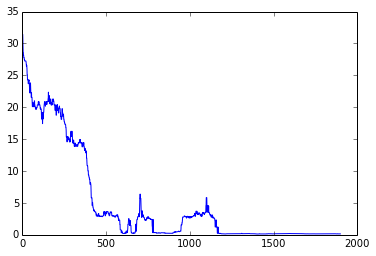

In [100]:
y = median_smoothing(errors[::100], window=100)
plt.plot(range(len(y)), y)


In [101]:
for param in ntm_model.parameters():
    nel = param.w.ravel().shape[0]
    avg = sum(sum(abs(param.w))) / nel
    nrm =  np.linalg.norm(param)
    print('%.3f\t%.3f\t%d\t%s' % (avg, nrm,nel, param.name))
# plt.colorbar()

0.225	8.744	800	ntm_controller_mlp_input_layer_W0
0.452	25.454	2000	ntm_controller_mlp_input_layer_W1
0.472	5.867	100	ntm_controller_mlp_input_layer_b
0.540	19.681	800	ntm_decoder_W0
2.455	8.069	8	ntm_decoder_b
0.165	9.597	2000	ntm_read_head0_adressing_content_key_W0
1.155	7.058	20	ntm_read_head0_adressing_content_key_b
0.422	5.197	100	ntm_read_head0_adressing_content_key_strength_W0
2.557	2.557	1	ntm_read_head0_adressing_content_key_strength_b
0.130	1.603	100	ntm_read_head0_adressing_interpolation_W0
1.558	1.558	1	ntm_read_head0_adressing_interpolation_b
0.358	239.336	12800	ntm_read_head0_adressing_shift_W0
0.501	33.445	128	ntm_read_head0_adressing_shift_b
0.159	2.002	100	ntm_read_head0_adressing_focus_W0
0.175	0.175	1	ntm_read_head0_adressing_focus_b
4.545	54.356	128	ntm_read_head0_adressing_initial_locations
0.215	12.362	2000	ntm_write_head0_adressing_content_key_W0
1.758	9.412	20	ntm_write_head0_adressing_content_key_b
0.360	4.741	100	ntm_write_head0_adressing_content_key_strength_

In [30]:
x.ravel().shape[0]

4

In [91]:
ntm_model.read_heads[0].addressing.initial_locations.w
# plt.colorbar()

array([[ 0.8116377 ,  0.59566122,  0.49466214,  0.46039918,  0.61630201,
        -0.33986348,  0.12560712,  0.58555883,  0.5218761 ,  0.33090848,
         0.51518619,  0.8930847 ,  0.96688551,  0.63240188,  0.55799574,
         0.55299872,  0.61381924,  1.00473475,  1.09844375,  0.75794619,
         0.18987241, -0.09666262,  0.65739894,  0.60510671,  0.26888797,
         0.34444487,  0.34612277,  0.38025174,  0.6011349 ,  0.88652372,
         1.00608325,  0.89585954,  0.95290732,  0.79351598,  1.00413716,
         0.64029497, -0.45334938, -0.09486344,  0.01748658, -0.44612688,
        -0.57601643, -0.67443895, -0.90790713, -1.02970672, -0.94918191,
        -0.89001358, -0.98256266, -1.15215051, -1.4409796 , -1.41517532,
        -1.40730977, -1.27923059, -0.32512578,  0.26151612,  0.49421379,
         0.77482742,  0.5601601 ,  0.09498564,  0.7505185 ,  1.13843215,
         0.79770923, -0.0198104 , -0.3197937 , -0.27566588, -0.29326198,
         0.15073785,  0.06546709, -0.01024877, -0.9

In [92]:
h = ntm_model.read_heads[0]

plt.matshow(h.addressing.shift)
plt.colorbar()

ValueError: need more than 0 values to unpack

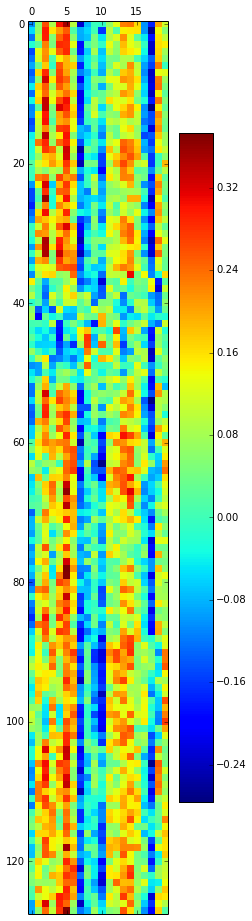

In [93]:
plt.matshow(ntm_model.memory_init)
plt.colorbar()

input_vec [ 0.  0.  0.  1.  0.  1.  1.  0.]
decoded   [ 0.  0.  0.  1.  0.  1.  1.  0.]

input_vec [ 0.  1.  1.  1.  1.  0.  1.  0.]
decoded   [ 0.  1.  1.  1.  1.  0.  1.  0.]

input_vec [ 1.  1.  0.  0.  0.  0.  1.  1.]
decoded   [ 1.  1.  0.  0.  0.  0.  1.  1.]

input_vec [ 1.  0.  1.  0.  1.  0.  1.  0.]
decoded   [ 1.  0.  1.  0.  1.  0.  1.  0.]

input_vec [ 0.  0.  1.  0.  0.  1.  0.  1.]
decoded   [ 0.  0.  1.  0.  0.  1.  0.  1.]

input_vec [ 0.  0.  1.  1.  0.  1.  0.  1.]
decoded   [ 0.  0.  1.  1.  0.  1.  0.  1.]

input_vec [ 0.  0.  0.  0.  0.  0.  0.  0.]
decoded   [ 0.  0.  0.  0.  0.  0.  0.  0.]

input_vec [ 0.  0.  0.  1.  1.  1.  1.  1.]
decoded   [ 0.  0.  0.  1.  1.  1.  1.  1.]

input_vec [ 0.  0.  1.  0.  0.  1.  0.  1.]
decoded   [ 0.  0.  1.  0.  0.  1.  0.  1.]

input_vec [ 0.  0.  1.  1.  0.  0.  0.  1.]
decoded   [ 0.  0.  1.  1.  0.  0.  0.  1.]

dict_keys(['write_head_weights', 'write_head_content', 'read_head_weights', 'read_head_content'])
At tstep 0 R

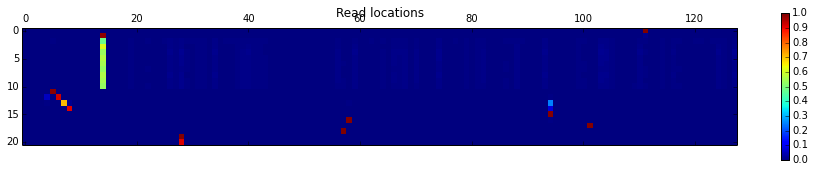

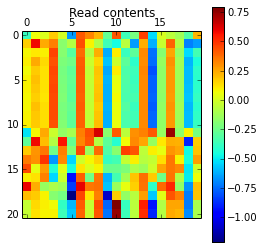

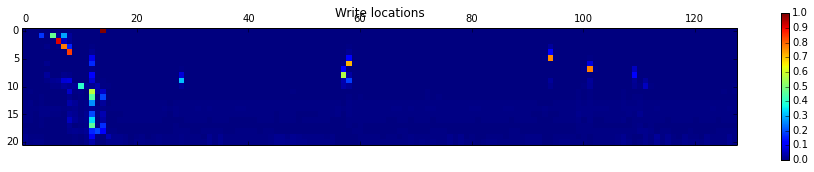

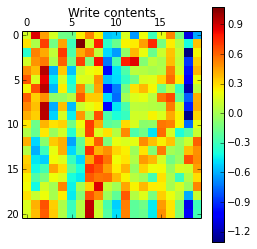

In [104]:
def combine_access(accesses):
    num_accesses = len(accesses)
    assert(num_accesses > 0)
    mem_locations = accesses[0].shape[1]
    res = np.zeros((num_accesses, mem_locations))
    norms = []
    for idx, access in enumerate(accesses):
        assert(access.shape == (1, mem_locations))
        res[idx] = access.w[0]
        norms.append(np.linalg.norm(access.w[0]))
    return res, norms

def inspect(model):
    start_prediction = D.Mat.ones((1,INPUT_SIZE), constant=True)
    c = Capture()
    with D.NoBackprop():
        with c:
            example = generate_example(INPUT_SIZE, MAX_TRAIN_SEQ_LENGTH)
            state = model.initial_states()
            for input_vec in example:
                state = model.activate(input_vec, state)

            state = model.activate(start_prediction, state)
            for input_vec in example:
                decoded = np.round(model.decode(state).sigmoid().w)
                print("input_vec", input_vec.w[0])
                print("decoded  ",   decoded[0])
                print("")
                state = model.activate(start_prediction, state)
    reads, read_norms  = combine_access(c.state["read_head_weights"])
    writes, write_norms = combine_access(c.state["write_head_weights"])
    
    print(c.state.keys())
    
    plt.figure()
    r = plt.matshow(reads)
    plt.title("Read locations")
    plt.colorbar(r)
    
    read_contents, _ = combine_access(c.state["read_head_content"])
    plt.figure()
    r = plt.matshow(read_contents)
    plt.title("Read contents")
    plt.colorbar(r)
    
    plt.figure()
    w = plt.matshow(writes)
    plt.title("Write locations")
    plt.colorbar(w)
    
    write_contents, _ = combine_access(c.state["write_head_content"])
    plt.figure()
    r = plt.matshow(write_contents)
    plt.title("Write contents")
    plt.colorbar(r)
    
    for idx, (read_n, write_n) in enumerate(zip(read_norms, write_norms)):
        print("At tstep %d READ: %.3f, WRITE: %.3f" % (idx, read_n, write_n))

inspect(ntm_model)

In [ ]:
c.state["read_head"][1].shape

In [ ]:
ntm_model.__class__ = NTM
for h in ntm_model.read_heads:
    h.__class__ = NTMReadHead
for h in ntm_model.write_heads:
    h.__class__ = NTMWriteHead

In [ ]:
ntm_model.write_heads[0].__class__ = NTMWriteHead

In [ ]:
A = D.Mat([[1,1,1],[2,2,2]])
B = D.Mat([[1,2,3]])

In [ ]:
print(A.w)
print(B.w)
A/ D.MatOps.broadcast(B, axis=0, num_replicas=2)

In [ ]:
A.w.mean(axis=0)

In [ ]:
A.softplus()

In [ ]:
A = D.Mat([1,2,3])

In [ ]:
D.Mat([1,2,3]) * D.Mat([2])

In [ ]:
x = D.random.uniform(-1,1, (1,1)).sum(0)

In [ ]:
D.MatOps.broadcast(x, axis=0, num_replicas=20)

In [ ]:
x = D.random.uniform(-1,1, (1,2))
y = D.random.uniform(-1,1, (1,3))

In [ ]:
x

In [ ]:
y

In [ ]:
y.dot(x)

In [ ]:
ax = plt.subplots(2,2)

In [ ]:
ax

In [ ]:
1.0 - D.Mat.ones((2,3))